#### Зимняя школа CompTech
# Прогноз спроса и планирование рабочих смен

Подзадача 2. В зависимости, сколько будет в i-ый час заказов, рассчитать, сколько надо курьеров

Оптимальное количество курьеров: delay rate < 5%

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

data_orders = pd.read_csv('./data/orders.csv', parse_dates=['date'])
data_partners = pd.read_csv('./data/partners_delays.csv', parse_dates=['dttm'])
data_orders.columns = ['delivery_area_id', 'dttm', 'orders_cnt']

In [2]:
df = pd.merge(data_orders, data_partners, on=['dttm', 'delivery_area_id'], how='inner')
df['date'] = df['dttm'].dt.date
df['order_p_partner'] = df['orders_cnt'] / df['partners_cnt']
delay_threshold = 0.05
df['delay'] = np.where(df['delay_rate'] <= delay_threshold, 0, 1)
df['orders_cnt_delayed'] = df['orders_cnt'] * df['delay_rate']

df.head()


,delivery_area_id,dttm,orders_cnt,partners_cnt,delay_rate,date,order_p_partner,delay,orders_cnt_delayed
0,0,2021-04-01 10:00:00,9,4.0,0.111111,2021-04-01,2.25,1,1.0
1,0,2021-04-01 11:00:00,1,4.0,0.000000,2021-04-01,0.25,0,0.0
2,0,2021-04-01 13:00:00,1,1.0,0.000000,2021-04-01,1.00,0,0.0
3,0,2021-04-01 14:00:00,1,1.0,0.000000,2021-04-01,1.00,0,0.0
4,0,2021-04-01 15:00:00,2,1.0,0.000000,2021-04-01,2.00,0,0.0


count    593.000000
mean       0.047286
std        0.016635
min        0.017442
25%        0.035758
50%        0.044612
75%        0.056736
max        0.120906
Name: global_delay_share, dtype: float64

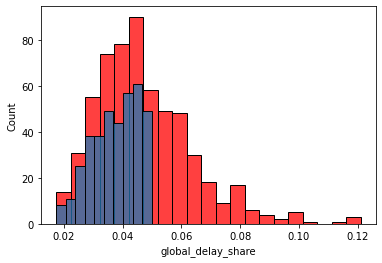

In [3]:
df_delays = df.groupby('delivery_area_id')[['orders_cnt', 'orders_cnt_delayed']].sum()
df_delays['global_delay_share'] = df_delays['orders_cnt_delayed'] / df_delays['orders_cnt']

# saving id of delivery areas where global delay rate <= threshold
delivery_area_good_stat = list(df_delays[df_delays['global_delay_share'] <= delay_threshold].index)

# plot global delay rate
sns.histplot(data=df_delays, x='global_delay_share', color='r')
sns.histplot(data=df_delays[df_delays.index.isin(delivery_area_good_stat)], x='global_delay_share')
df_delays['global_delay_share'].describe()

count    884856.000000
mean          1.500624
std           0.579608
min           0.052632
25%           1.000000
50%           1.500000
75%           2.000000
max           3.142857
Name: order_p_partner, dtype: float64

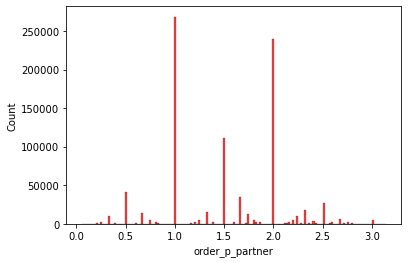

In [4]:
sns.histplot(data=df, x='order_p_partner', color='r')
df['order_p_partner'].describe()

count    380.000000
mean       1.806930
std        0.694067
min        0.200000
25%        1.000000
50%        2.000000
75%        2.333333
max        3.000000
Name: order_p_partner, dtype: float64

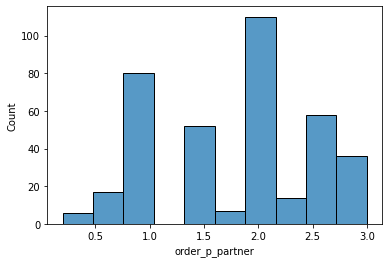

In [5]:
sns.histplot(data=df[df.index.isin(delivery_area_good_stat)], x='order_p_partner')
df[df.index.isin(delivery_area_good_stat)]['order_p_partner'].describe()

In [6]:
def get_bootstrap_ci(df, num_experiments=1000, alpha=0.05):
    '''
    Функция считает доверительный интервал (двусторонний) при помощи бутстрэпа.
    ---
    Параметры:
        df               -- датафрейм
        num_experiments  -- количество экспериментов в симуляции
        alpha            -- уровень значимости  
    
    '''
    # формируем выборку CTR
    mean_data = []
    for i in range(num_experiments):
        sample = df.sample(frac=0.5, replace=True)
        mean = sample.mean()
        mean_data.append(mean)
    
    # рассчитываем границы доварительного интервала
    ci = np.percentile(mean_data, [100 * alpha / 2.0, 100 * (1 - alpha / 2.0)])
    
    return ci

# устанавливаем уровень значимости
alpha=0.05

In [7]:
# рассчитываем доверительный интервал - фильтр на уровне самого датасета (опоздания <= трешхолд)
low, high = get_bootstrap_ci(
    df[df['delay_rate'] <= delay_threshold]['order_p_partner'], num_experiments=1000, alpha=alpha)
message = f'{(1-alpha):.2f} доверительный интервал составляет [{low:.3f}; {high:.3f}]'
print(message)

0.95 доверительный интервал составляет [1.404; 1.407]


In [8]:
# рассчитываем доверительный интервал - фильтр на уровне global delay rate (опоздания <= трешхолд)
low, high = get_bootstrap_ci(
    df[df.index.isin(delivery_area_good_stat)]['order_p_partner'], num_experiments=1000, alpha=alpha)
message = f'{(1-alpha):.2f} доверительный интервал составляет [{low:.3f}; {high:.3f}]'
print(message)

0.95 доверительный интервал составляет [1.706; 1.904]


In [ ]:
# рассчитываем доверительный интервал по всему датасету
low, high = get_bootstrap_ci(
    df['order_p_partner'], num_experiments=1000, alpha=alpha)
message = f'{(1-alpha):.2f} доверительный интервал составляет [{low:.3f}; {high:.3f}]'
print(message)